# Face Recognition Using Siamese Network

Note: this notebook is adapted from (from [Packt tutorial](https://hub.packtpub.com/face-recognition-using-siamese-networks-tutorial/), which seems to be a re-implementation from  [this Packt book on Neural Network Projects with Python](https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781789138900)). See also [this Hackernoon tutorial](https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e).

We can better understand siamese networks by building such a system for  face recognition. 
The objective of this network is to measure how two faces are similar or dissimilar. 


## import required packages

In [78]:
import numpy as np
import numpy.random as rng

from pathlib import Path

import os
import matplotlib.pyplot as plt
%matplotlib inline

# to be used with the plaidml backend 
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import plaidml.keras
plaidml.keras.install_backend()

from keras.models import Sequential
from keras.optimizers import Adam
from keras.optimizers import RMSprop

from keras.layers import Dropout, Conv2D, Convolution2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# local routine for loading images
from localmodules.datasets import load_faces, get_dimensions, get_siamese_paired_data
# local routine for constructing siamese network
from localmodules.models import create_siamese_model, contrastive_loss, accuracy


#### Import face image data sets (Olivetti (AT&T), Labeled Faces in the Wild, Caltech)

This is similar to the EigenFaces assignment import module

The data are returned as a list object with the following components:
* data: (NxM) matrix of N flattened (linear dimension M) images
* images: (Nx(nxm)) matrix of N images of dimension nxm 
* target: N-dimensional vector of labels 

In [79]:
# path to dataset for Caltech data
caltechDataset = Path("./CalTechFacesDirs")
# type of database (ATT/LFW/CALTECH)
facesDB = "ATT"
# max number of persons to extract from database
max_persons = None

In [80]:
# Download the data, if not already on disk and load it as numpy arrays

faces_att = load_faces("ATT", dataset = None, min_faces=10, max_targets=max_persons)

faces_lfw = load_faces("LFW", dataset = None, min_faces=10, max_targets=max_persons)

faces_cal = load_faces("CALTECH", dataset = caltechDataset, min_faces=10, max_targets=max_persons)
    # convert string label to unique numeric id
  



## Print statistics of data set

In [83]:
n_samples, n_examples, n_classes, n_features, height, width, channels = get_dimensions(faces_att)
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_examples: %d" % n_examples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
print("width: %d" % width)
print("height: %d" % height)
print("channels: %d" % channels)

print(faces_att)

Total dataset size:
n_samples: 400
n_examples: 10
n_features: 4096
n_classes: 40
width: 64
height: 64
channels: 1
{'data': array([[0.30991736, 0.3677686 , 0.41735536, ..., 0.15289256, 0.16115703,
        0.1570248 ],
       [0.45454547, 0.47107437, 0.5123967 , ..., 0.15289256, 0.15289256,
        0.15289256],
       [0.3181818 , 0.40082645, 0.49173555, ..., 0.14049587, 0.14876033,
        0.15289256],
       ...,
       [0.5       , 0.53305787, 0.607438  , ..., 0.17768595, 0.14876033,
        0.19008264],
       [0.21487603, 0.21900827, 0.21900827, ..., 0.57438016, 0.59090906,
        0.60330576],
       [0.5165289 , 0.46280992, 0.28099173, ..., 0.35950413, 0.3553719 ,
        0.38429752]], dtype=float32), 'images': array([[[0.30991736, 0.3677686 , 0.41735536, ..., 0.37190083,
         0.3305785 , 0.30578512],
        [0.3429752 , 0.40495867, 0.43801653, ..., 0.37190083,
         0.338843  , 0.3140496 ],
        [0.3429752 , 0.41735536, 0.45041323, ..., 0.38016528,
         0.338843  ,

## Construct siamese set from initial set.

The siamese set contains pairs of images that are labeled as either imposter (label 1) or genuine (label 0).

*N_siamese* is the number of such pairs you generate.

See the localmodules.dataset file for details how they are generated

In [84]:
N_siamese = 10000 # max n_samples**2
X_att, y_att = get_siamese_paired_data(faces_att, N_siamese)
X_lfw, y_lfw = get_siamese_paired_data(faces_lfw, N_siamese)
# X_cal, y_cal = get_siamese_paired_data(faces_cal, N_siamese)


In [85]:
X_att.shape

(20000, 2, 64, 64, 1)

## Split in training and test set

In [86]:
x_train, x_test, y_train, y_test = train_test_split(X_att, y_att, test_size=.25, shuffle = False)

Verify by random sampling if genuine and imposter pairs are correctly constructed

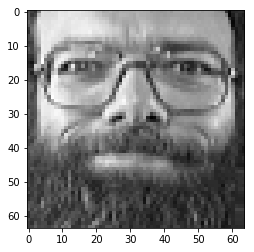

In [8]:
subj_nr = 14000

plt.imshow(np.squeeze(x_train[subj_nr,0]),cmap='gray');  

1.0


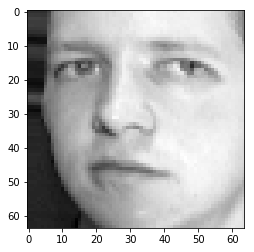

In [9]:
plt.imshow(np.squeeze(x_train[subj_nr,1]),cmap='gray'); 
y_train[subj_nr]
print(y_train[subj_nr])

## Simple CNN Model

The localmodules.models file contains the description of a shallow CNN model that is trained with [contrastive loss](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).
This subnetwork is copied twice and the output of both siamese copies are then passed onto a vector euclidean distance (ED) calculation layer. The network gets as input pairs of imposter or genuine images with the associated label (genuine = 0, imposter = 1).

The network itself outputs the ED betweeen pairs of embedded representations (right before the distance calculation). Use this distance measure for verification and identification tests.

Note: you can change the CNN at your will, but beware that it might take additional training time.

In [10]:
model = create_siamese_model(x_train.shape[2:])
model.summary()

INFO:plaidml:Opening device "opencl_nvidia_geforce_gtx_1050.0"


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          1680832     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_1[1][0]               
          

Print the network graph

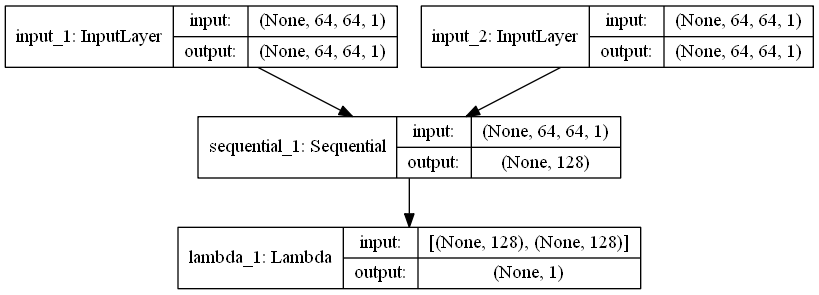

In [11]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from keras.utils import plot_model
plot_model(model, to_file='model.png', 
           show_shapes = True, show_layer_names = True)

from IPython.display import Image
Image(retina=True, filename='model.png')

The network will be trained with contrastive loss as objective function and Adam optimizer. It outputs an additional accuracay measure (which uses an arbitrarily set threshold = 0.5). The threshold can be determined later on through e.g. max F1-score

In [12]:
from keras.optimizers import RMSprop

rms = Adam()
model.compile(loss=contrastive_loss, optimizer=rms, metrics = [accuracy])

### Fit/train the model. 

Depending on the complexity of the Siamese network this might take a while. You can also change the number of epochs to improve the training (with the risk of overfitting). You will notice that a small number (<10) of epochs already gets you a decent performance


In [13]:
epochs = 8
model.fit([x_train[:, 0], x_train[:, 1]], y_train, 
          validation_split=.25,
          batch_size=64, verbose=2, epochs=epochs)

Train on 11250 samples, validate on 3750 samples
Epoch 1/8


INFO:plaidml:Analyzing Ops: 118 of 253 operations complete
INFO:plaidml:Analyzing Ops: 116 of 253 operations complete


 - 27s - loss: 0.0328 - accuracy: 0.9205 - val_loss: 0.1138 - val_accuracy: 0.6008
Epoch 2/8
 - 21s - loss: 0.0201 - accuracy: 0.9644 - val_loss: 0.0887 - val_accuracy: 0.7053
Epoch 3/8
 - 21s - loss: 0.0155 - accuracy: 0.9766 - val_loss: 0.0500 - val_accuracy: 0.8632
Epoch 4/8
 - 21s - loss: 0.0120 - accuracy: 0.9845 - val_loss: 0.0467 - val_accuracy: 0.8693
Epoch 5/8
 - 21s - loss: 0.0088 - accuracy: 0.9903 - val_loss: 0.0235 - val_accuracy: 0.9544
Epoch 6/8
 - 21s - loss: 0.0068 - accuracy: 0.9942 - val_loss: 0.0234 - val_accuracy: 0.9536
Epoch 7/8
 - 21s - loss: 0.0055 - accuracy: 0.9957 - val_loss: 0.0163 - val_accuracy: 0.9717
Epoch 8/8
 - 21s - loss: 0.0044 - accuracy: 0.9968 - val_loss: 0.0119 - val_accuracy: 0.9781


### For further testing it might be worthwhile saving a time-consuming trained network

In [14]:
model.save("siamese_nn.h5")

### Apply the network to the test data

In [15]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

In [16]:
x_test[:,0].shape

(5000, 64, 64, 1)

In [17]:
print(pred)

[[0.65345585]
 [0.7488376 ]
 [1.8345871 ]
 ...
 [1.912823  ]
 [1.1833409 ]
 [1.3095316 ]]


### Calculate accuracy (for an arbitrary threshold of the distance set at 0.5)

In [18]:
def compute_accuracy(predictions, labels):
    print(labels[predictions.ravel() > 0.5])
    return labels[predictions.ravel() > 0.5].sum()/len(predictions.ravel())

In [19]:
compute_accuracy(pred, y_test)

[1. 1. 1. ... 1. 1. 1.]


0.973

### Calculate pairwise distances for further analysis

In [20]:
# from localmodules.distance import L2_distance
from tqdm import tqdm_notebook
import numpy.random as rng

distances = [] # distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = int(n_samples/2)
samples = rng.choice(n_samples,size=num,replace=False)

# num = n_samples
I = np.zeros((num, num))

for i in tqdm_notebook(range(num-1)):
    for j in range(i, num):
        # Euclidean norm as distance
        imgi = np.expand_dims(faces.images[i], axis = 0)
        imgi = np.expand_dims(imgi, axis = 3)

        imgj = np.expand_dims(faces.images[j], axis = 0)
        imgj = np.expand_dims(imgj, axis = 3)

        distances.append(model.predict([imgi, imgj])[0][0])
        if faces.target[i] == faces.target[j]:
            identical.append(True)
            I[i,j] =  I[j,i] = 1
        else:
            identical.append(False)
        
distances = np.array(distances)
# convert to normalized [0,1] score (the higher the better)
scores = (distances.max() - distances)/distances.max()
identical = np.array(identical)

### Compute accuracy and F1 scores for different thresholds

From here on, you can apply the same techniques as fot PCA/LBP based face recognition


In [21]:
from sklearn.metrics import f1_score, accuracy_score

def show_metrics(scores, identical, show, title):
    # set threshold range
    thresholds =  np.arange(0,1,0.03)

    f1_scores = []
    acc_scores = []
    for th in thresholds:
        scores_th = np.where(scores > th, 1, 0)
        f1_scores.append(f1_score(identical, scores_th))
        acc_scores.append(accuracy_score(identical, scores_th))


    # Determine optimal Threshold 
    # ...
    opt_tau = thresholds[np.argmax(f1_scores)]
    # ...
    print(opt_tau)

    # Plot F1 score and accuracy as function of distance threshold
    if show:
        plt.scatter(thresholds, f1_scores, c='b', label='F1 scores')
        plt.scatter(thresholds, acc_scores, c='r', label='accuracy scores')
        plt.legend()
        plt.xlabel('threshold')
        plt.xlabel('score')
        plt.title(title)
        plt.show()
    return opt_tau

0.84


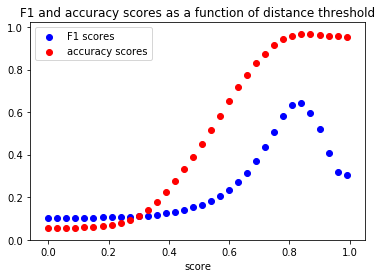

In [23]:
opt_tau = show_metrics(scores, identical, show=True, title='F1 and accuracy scores as a function of distance threshold')

### Plot genuine and imposter scores

In [55]:
def show_genuine_impostor(scores, identical, opt_tau, name):
    gen = scores[np.where(identical==1)]
    imp = scores[np.where(identical==0)]
    plt.hist(gen, density=False, bins=50, label='genuine')
    plt.hist(imp, density=False, alpha=0.5, bins=50, label='impostor')
    
    plt.xlabel('score', fontsize=16)
    plt.ylabel('number', fontsize=16)
    plt.axvline(x=opt_tau, color='r', linestyle='--', label='threshold')
    plt.legend()
    plt.title(name, fontsize=18)
    plt.show()


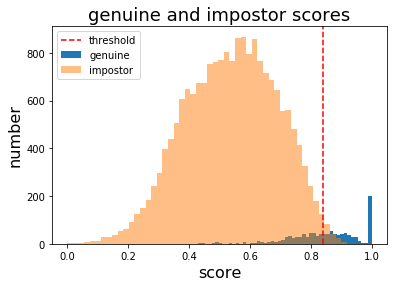

In [56]:
show_genuine_impostor(scores, identical, opt_tau, 'genuine and impostor scores')

In [61]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d

def show_roc(scores_arr, identical_arr, names):
    EER_arr = []
    plt.title('Receiver Operating Characteristic', fontsize=18)
    
    plt.plot([0, 1], [1, 0],'r--')
    plt.plot([0, 1], [0, 1],'k-')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.xlabel('False Positive Rate', fontsize=18)
    colors = ['b','g','r']
    for i in range(len(scores_arr)):
        fpr, tpr, threshold = roc_curve(identical_arr[i], scores_arr[i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, colors[i], linewidth=3, label = '%s AUC = %0.3f' % (names[i],roc_auc))
        fnr = 1 - tpr

        eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
        EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
        EER2 = fnr[np.nanargmin(np.absolute((fnr - fpr)))]
        print("%s Equal error rate: %.3f" % (names[i], EER))
        EER_arr.append(EER)
    plt.legend(loc = 'lower right')
    plt.show()

    
    return EER_arr

ROC curve Equal error rate: 0.123


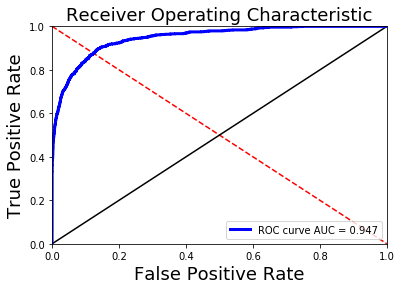

In [62]:
[EER] = show_roc([scores],[identical], ['ROC curve'])

#### Caluclate classification scores
* plot precision-recall curve
* calculate AUC
* average precision
* others?

In [48]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score


def show_precision_recall(scores_arr, identical_arr, opt_tau_arr):
    colors = ['b','g','r']
    for i in range(len(scores_arr)):
        precision, recall, thresholds = precision_recall_curve(identical_arr[i], scores_arr[i])
        scores_th = np.where(scores_arr[i] > opt_tau_arr[i], 1, 0)
        f1 = f1_score(identical_arr[i], scores_th)

        auc_ = auc(recall, precision)

        ap = average_precision_score(identical_arr[i], scores_arr[i])
        print(' f1=%.3f auc=%.3f ap=%.3f' % ( f1, auc_, ap))
        plt.plot(recall, precision, colors[i], marker='.',linewidth=1, label = 'AUC = %0.3f' % ( auc_))
   
    plt.plot([0, 1], [0.5, 0.5], 'k--') 
    plt.xlabel('recall', fontsize= 18)
    plt.ylabel('precision', fontsize= 18)
    plt.show()

 f1=0.643 auc=0.721 ap=0.721


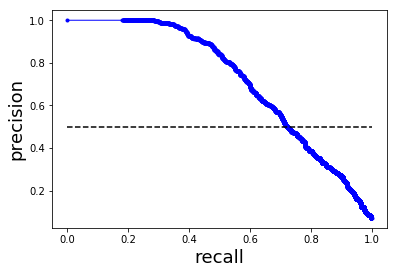

In [49]:
show_precision_recall([scores],[identical],[opt_tau])